In [1]:
pip install -r https://raw.githubusercontent.com/rizki96/ds_challenge/master/requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import io
import bz2
import pandas as pd
import numpy as np
import geohash
import datetime
import pprint
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import requests
from math import ceil
from sklearn import preprocessing
from sklearn.cluster import DBSCAN
from shapely.geometry import MultiPoint
from geopy.distance import great_circle
from pandas.plotting import register_matplotlib_converters
from collections import OrderedDict
from itertools import islice

register_matplotlib_converters()

In [3]:
# from local data file
trf_df = pd.read_csv('training.csv.bz2', compression='bz2', header=0, sep=',', quotechar='"')
trf_df_sort = trf_df.sort_values(by=['day', 'timestamp'])

# from remote data file
#url="https://github.com/rizki96/ds_challenge/blob/master/Traffic%20Management/training.csv.bz2?raw=true"
#s=requests.get(url).content
#data = bz2.decompress(s)
#trf_df = pd.read_csv(io.BytesIO(data), header=0, sep=',', quotechar='"')
#trf_df_sort = trf_df.sort_values(by=['day', 'timestamp'])

In [4]:
trf_df_sort[:5]

,geohash6,day,timestamp,demand
2289,qp09sx,1,0:0,0.021212
3149,qp0dhg,1,0:0,0.013217
11052,qp03x5,1,0:0,0.157956
23011,qp09bw,1,0:0,0.001262
26180,qp03wn,1,0:0,0.032721


In [5]:
trf_df_sort["dts_cal"] = [datetime.datetime.strptime('2019-03-31 00:00:00.00', '%Y-%m-%d %H:%M:%S.%f') + datetime.timedelta(days=day, hours=int(timestamp.split(":")[0]), minutes=int(timestamp.split(":")[1])) for day,timestamp in trf_df_sort[["day", "timestamp"]].values]

In [6]:
trf_df_sort[:5]

,geohash6,day,timestamp,demand,dts_cal
2289,qp09sx,1,0:0,0.021212,2019-04-01
3149,qp0dhg,1,0:0,0.013217,2019-04-01
11052,qp03x5,1,0:0,0.157956,2019-04-01
23011,qp09bw,1,0:0,0.001262,2019-04-01
26180,qp03wn,1,0:0,0.032721,2019-04-01


# data point population count

In [7]:
dt_count = {dtstamp[0]: 0 for dtstamp in trf_df_sort[['day']].values}

In [8]:
for dtstamp in trf_df_sort[['day']].values:
    dt_count[dtstamp[0]] += 1

In [9]:
dt_count = [(d, dt_count[d]) for d in dt_count]
ts, points = zip(*dt_count)
dt_frame = pd.DataFrame({'ts': ts, 'pcounts': points})
dt_frame[:5]

,ts,pcounts
0,1,67627
1,2,70452
2,3,69966
3,4,72609
4,5,67279


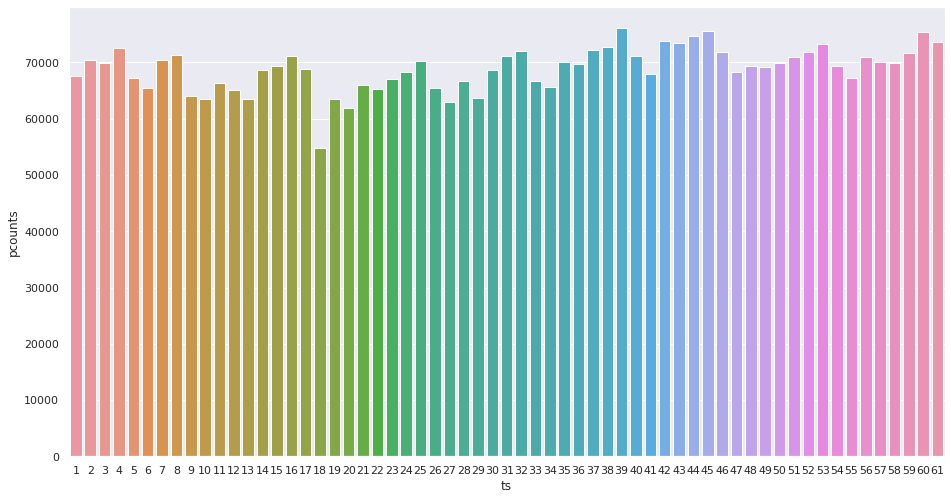

In [10]:
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(15.7,8.27)})
sns.barplot(data=dt_frame, x='ts', y='pcounts')
plt.show()

# average demand per day

In [11]:
avg_demand_day = trf_df_sort.groupby(['day'])['demand'].apply(lambda x: np.mean(x))
dt_frame['avg_demand_day'] = [a for a in avg_demand_day]
dt_frame[:5]

,ts,pcounts,avg_demand_day
0,1,67627,0.093651
1,2,70452,0.109683
2,3,69966,0.108904
3,4,72609,0.120707
4,5,67279,0.094623


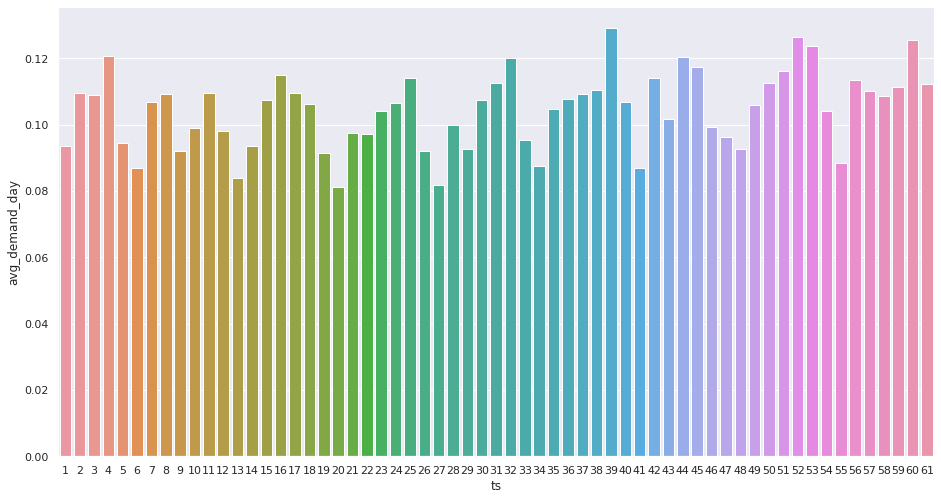

In [12]:
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(15.7,8.27)})
sns.barplot(data=dt_frame, x='ts', y='avg_demand_day')
plt.show()

# convert geohash into latitude longitude

In [13]:
trf_df_sort.loc[:, 'latlon'] = trf_df_sort.geohash6.map(lambda x: geohash.decode(x))
trf_df_sort['lat'] = [ll[0][0] for ll in trf_df_sort[['latlon']].values]
trf_df_sort['lon'] = [ll[0][1] for ll in trf_df_sort[['latlon']].values]

In [14]:
trf_df_sort[:5]

,geohash6,day,timestamp,demand,dts_cal,latlon,lat,lon
2289,qp09sx,1,0:0,0.021212,2019-04-01,"(-5.32012939453125, 90.9063720703125)",-5.320129,90.906372
3149,qp0dhg,1,0:0,0.013217,2019-04-01,"(-5.25421142578125, 90.9173583984375)",-5.254211,90.917358
11052,qp03x5,1,0:0,0.157956,2019-04-01,"(-5.34210205078125, 90.6646728515625)",-5.342102,90.664673
23011,qp09bw,1,0:0,0.001262,2019-04-01,"(-5.28167724609375, 90.7305908203125)",-5.281677,90.730591
26180,qp03wn,1,0:0,0.032721,2019-04-01,"(-5.32562255859375, 90.6207275390625)",-5.325623,90.620728


# week 1 data

In [15]:
initial_day = 1
num_of_days = 7
range_btwn_pts = 1 # in km
min_samples = 1
trf_week1 = pd.DataFrame(trf_df_sort[(trf_df_sort.day >= initial_day) & (trf_df_sort.day < (initial_day + num_of_days))])

In [16]:
trf_week1[:5]

,geohash6,day,timestamp,demand,dts_cal,latlon,lat,lon
2289,qp09sx,1,0:0,0.021212,2019-04-01,"(-5.32012939453125, 90.9063720703125)",-5.320129,90.906372
3149,qp0dhg,1,0:0,0.013217,2019-04-01,"(-5.25421142578125, 90.9173583984375)",-5.254211,90.917358
11052,qp03x5,1,0:0,0.157956,2019-04-01,"(-5.34210205078125, 90.6646728515625)",-5.342102,90.664673
23011,qp09bw,1,0:0,0.001262,2019-04-01,"(-5.28167724609375, 90.7305908203125)",-5.281677,90.730591
26180,qp03wn,1,0:0,0.032721,2019-04-01,"(-5.32562255859375, 90.6207275390625)",-5.325623,90.620728


# day 1 to day 4 cluster

In [17]:
day_ids = list(range(1,5))
trf_day1 = pd.DataFrame(trf_week1[trf_week1.day.isin(day_ids)])
coords = trf_day1[['lat', 'lon']].values

In [18]:
kms_per_radian = 6371.0088
epsilon = range_btwn_pts / kms_per_radian
db = DBSCAN(eps=epsilon, min_samples=min_samples, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
# mark as -1 for outliers
clusters = pd.Series([coords[cluster_labels == n] for n in range(-1, num_clusters) if coords[cluster_labels == n].any()])
#clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters) if coords[cluster_labels == n].any()])
#num_clusters = len(clusters)
print('Number of day {} to day {} clusters: {}'.format(day_ids[0], day_ids[-1], num_clusters))
clusters

Number of day 1 to day 4 clusters: 89


0     [[-5.32012939453125, 90.9063720703125], [-5.35...
1     [[-5.25421142578125, 90.9173583984375], [-5.32...
2     [[-5.34210205078125, 90.6646728515625], [-5.29...
3     [[-5.28167724609375, 90.7305908203125], [-5.28...
4     [[-5.32562255859375, 90.6207275390625], [-5.35...
5     [[-5.40252685546875, 90.8184814453125], [-5.28...
6     [[-5.40252685546875, 90.6427001953125], [-5.35...
7     [[-5.29266357421875, 90.8624267578125], [-5.38...
8     [[-5.33111572265625, 90.6866455078125], [-5.39...
9     [[-5.29266357421875, 90.8514404296875], [-5.27...
10    [[-5.31463623046875, 90.6536865234375], [-5.27...
11    [[-5.32562255859375, 90.6976318359375], [-5.38...
12    [[-5.35308837890625, 90.7745361328125], [-5.36...
13    [[-5.39154052734375, 90.7086181640625], [-5.28...
14    [[-5.28717041015625, 90.8953857421875], [-5.34...
15    [[-5.32562255859375, 90.5987548828125], [-5.35...
16    [[-5.32012939453125, 90.7855224609375], [-5.32...
17    [[-5.34759521484375, 90.5877685546875], [-

# cluster centermost_points

In [19]:
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)
centermost_points = clusters.map(get_centermost_point)
centermost_points

0     (-5.32562255859375, 90.9063720703125)
1     (-5.33111572265625, 90.9173583984375)
2     (-5.33111572265625, 90.6646728515625)
3     (-5.28167724609375, 90.7305908203125)
4     (-5.35858154296875, 90.6207275390625)
5     (-5.33660888671875, 90.8184814453125)
6     (-5.33660888671875, 90.6427001953125)
7     (-5.35308837890625, 90.8624267578125)
8     (-5.36956787109375, 90.6866455078125)
9     (-5.35308837890625, 90.8514404296875)
10    (-5.33660888671875, 90.6536865234375)
11    (-5.34759521484375, 90.6976318359375)
12    (-5.33111572265625, 90.7745361328125)
13    (-5.34759521484375, 90.7086181640625)
14    (-5.30914306640625, 90.8953857421875)
15    (-5.36956787109375, 90.5987548828125)
16    (-5.34759521484375, 90.7855224609375)
17    (-5.37506103515625, 90.5877685546875)
18    (-5.36407470703125, 90.6097412109375)
19    (-5.35308837890625, 90.6756591796875)
20    (-5.35858154296875, 90.8734130859375)
21    (-5.26519775390625, 90.9283447265625)
22    (-5.29815673828125, 90.884

In [20]:
lats, lons = zip(*centermost_points)
rep_points = pd.DataFrame({'lon':lons, 'lat':lats})

In [21]:
rs = rep_points.apply(lambda row: trf_day1[(trf_day1['lat']==row['lat']) & (trf_day1['lon']==row['lon'])].iloc[0], axis=1)
rs[-5:]

,geohash6,day,timestamp,demand,dts_cal,latlon,lat,lon
84,qp09j5,1,2:15,0.022183,2019-04-01 02:15:00,"(-5.42999267578125, 90.9283447265625)",-5.429993,90.928345
85,qp03nf,1,2:15,0.009119,2019-04-01 02:15:00,"(-5.43548583984375, 90.6536865234375)",-5.435486,90.653687
86,qp09n4,1,9:30,0.001705,2019-04-01 09:30:00,"(-5.43548583984375, 90.9722900390625)",-5.435486,90.972290
87,qp09tv,4,10:15,0.013749,2019-04-04 10:15:00,"(-5.33111572265625, 90.9613037109375)",-5.331116,90.961304
88,qp08g4,3,23:45,0.000024,2019-04-03 23:45:00,"(-5.47943115234375, 90.8404541015625)",-5.479431,90.840454


# cluster member and centermost_point visualization

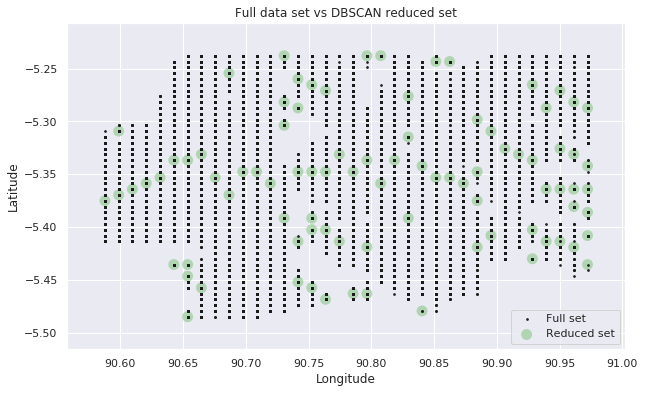

In [22]:
fig, ax = plt.subplots(figsize=[10, 6])
rs_scatter = ax.scatter(rs['lon'], rs['lat'], c='#99cc99', edgecolor='None', alpha=0.7, s=120)
df_scatter = ax.scatter(trf_day1['lon'], trf_day1['lat'], c='k', alpha=0.9, s=3)
ax.set_title('Full data set vs DBSCAN reduced set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter, rs_scatter], ['Full set', 'Reduced set'], loc='lower right')
plt.show()

# set label and is_centroid to cluster

In [23]:
# cluster_labels
trf_day1['cluster_ids'] = cluster_labels

In [24]:
trf_day1[:5]

,geohash6,day,timestamp,demand,dts_cal,latlon,lat,lon,cluster_ids
2289,qp09sx,1,0:0,0.021212,2019-04-01,"(-5.32012939453125, 90.9063720703125)",-5.320129,90.906372,0
3149,qp0dhg,1,0:0,0.013217,2019-04-01,"(-5.25421142578125, 90.9173583984375)",-5.254211,90.917358,1
11052,qp03x5,1,0:0,0.157956,2019-04-01,"(-5.34210205078125, 90.6646728515625)",-5.342102,90.664673,2
23011,qp09bw,1,0:0,0.001262,2019-04-01,"(-5.28167724609375, 90.7305908203125)",-5.281677,90.730591,3
26180,qp03wn,1,0:0,0.032721,2019-04-01,"(-5.32562255859375, 90.6207275390625)",-5.325623,90.620728,4


In [25]:
trf_day1 = trf_day1.sort_values(by=['cluster_ids', 'dts_cal', 'demand'])
trf_day1['is_centroid'] = [(rs['geohash6'][y] == x) for x,y in trf_day1[['geohash6', 'cluster_ids']].values]

In [26]:
trf_day1[-5:]

,geohash6,day,timestamp,demand,dts_cal,latlon,lat,lon,cluster_ids,is_centroid
1715016,qp09tv,4,10:15,0.013749,2019-04-04 10:15:00,"(-5.33111572265625, 90.9613037109375)",-5.331116,90.961304,87,True
114806,qp09ty,4,10:15,0.029731,2019-04-04 10:15:00,"(-5.32562255859375, 90.9613037109375)",-5.325623,90.961304,87,False
1739711,qp09ty,4,10:45,0.007523,2019-04-04 10:45:00,"(-5.32562255859375, 90.9613037109375)",-5.325623,90.961304,87,False
2351331,qp08g4,3,9:0,0.007090,2019-04-03 09:00:00,"(-5.47943115234375, 90.8404541015625)",-5.479431,90.840454,88,True
831234,qp08g4,3,23:45,0.000024,2019-04-03 23:45:00,"(-5.47943115234375, 90.8404541015625)",-5.479431,90.840454,88,True


# set highest_demand and average demand to cluster

In [27]:
trf_day1_avg_demand = trf_day1.groupby(['cluster_ids','geohash6'])['demand'].apply(lambda x: np.mean(x)).sort_values(ascending=False)
trf_day1['highest_demand'] = [trf_day1_avg_demand[x].index[0] == y for x,y in trf_day1[['cluster_ids', 'geohash6']].values]
trf_day1['avg_demand'] = [trf_day1_avg_demand[x][y] for x,y in trf_day1[['cluster_ids', 'geohash6']].values]

In [28]:
#trf_day1[(trf_day1.highest_demand == True) & (trf_day1.geohash6 == 'qp09jt')][:5]
trf_day1[(trf_day1.highest_demand == True)][-5:]

,geohash6,day,timestamp,demand,dts_cal,latlon,lat,lon,cluster_ids,is_centroid,highest_demand,avg_demand
1088182,qp09tu,4,4:45,0.051919,2019-04-04 04:45:00,"(-5.33660888671875, 90.9613037109375)",-5.336609,90.961304,87,False,True,0.016687
242088,qp09tu,4,5:0,0.008195,2019-04-04 05:00:00,"(-5.33660888671875, 90.9613037109375)",-5.336609,90.961304,87,False,True,0.016687
2804201,qp09tu,4,7:0,0.003976,2019-04-04 07:00:00,"(-5.33660888671875, 90.9613037109375)",-5.336609,90.961304,87,False,True,0.016687
2351331,qp08g4,3,9:0,0.007090,2019-04-03 09:00:00,"(-5.47943115234375, 90.8404541015625)",-5.479431,90.840454,88,True,True,0.003557
831234,qp08g4,3,23:45,0.000024,2019-04-03 23:45:00,"(-5.47943115234375, 90.8404541015625)",-5.479431,90.840454,88,True,True,0.003557


# visualize time, center point and highest demand

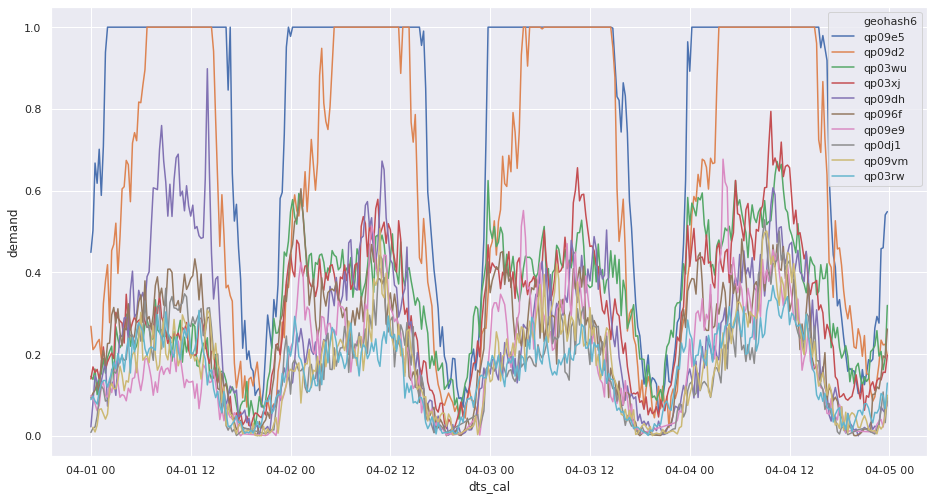

In [29]:
# observation 10 samples cluster's center point demand
trf_day1_center = pd.DataFrame(trf_day1[(trf_day1.is_centroid == True)].sort_values(by=['avg_demand', 'cluster_ids'], ascending=False))
top_clusters = list(OrderedDict.fromkeys([c[0] for c in trf_day1_center[['cluster_ids']].values]))[0:10]
top_trf_day1_center = trf_day1_center[(trf_day1_center.cluster_ids.isin(top_clusters))]
#trf_day1_cl0_others = pd.DataFrame(trf_day1[(trf_day1.is_centroid == False) & (trf_day1.cluster_ids == 0) & (trf_day1.demand > 0.0)])
#ax = sns.lineplot(x="dts_cal", y="demand", hue="geohash6", data=trf_day1_cl0_others, legend="full")
#for l in ax.lines:
#    l.set_linestyle("--")
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(15.7,8.27)})
sns.lineplot(x="dts_cal", y="demand", hue="geohash6", data=top_trf_day1_center, legend="full")
plt.show()

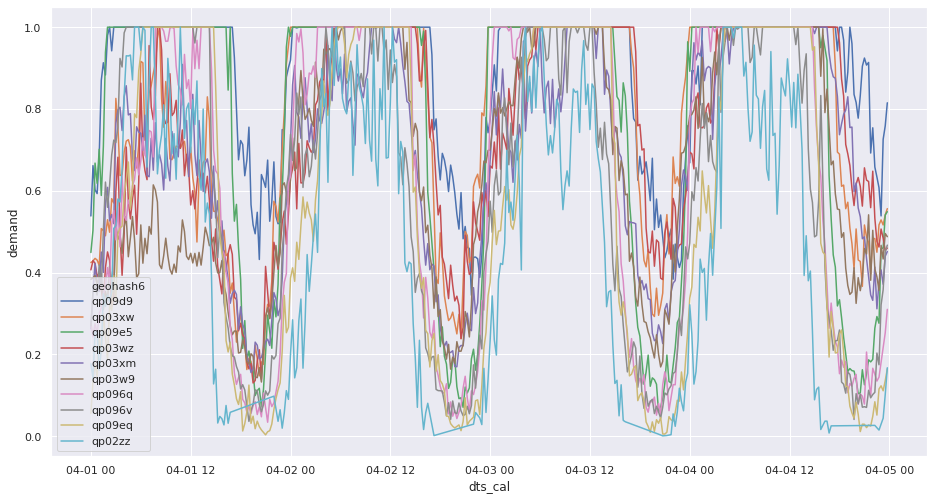

In [30]:
# observation 10 samples cluster's highest demand
trf_day1_highest = pd.DataFrame(trf_day1[(trf_day1.highest_demand == True)].sort_values(by=['avg_demand', 'cluster_ids'], ascending=False))
top_clusters = list(OrderedDict.fromkeys([c[0] for c in trf_day1_highest[['cluster_ids']].values]))[0:10]
top_trf_day1_highest = trf_day1_highest[(trf_day1_highest.cluster_ids.isin(top_clusters))]
#trf_week1_cl0_lower = pd.DataFrame(trf_week1[(trf_week1.highest_demand == False) & (trf_week1.cluster_ids == 0) & (trf_week1.demand > 0.0)])
#ax = sns.lineplot(x="dts_cal", y="demand", hue="geohash6", data=trf_week1_cl0_lower, legend="full")
#for l in ax.lines:
#    l.set_linestyle("--")
#    plt.setp(l,linewidth=1)
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(15.7,8.27)})
sns.lineplot(x="dts_cal", y="demand", hue="geohash6", data=top_trf_day1_highest, legend="full")
plt.show()

# zero filling timeseries gap for cluster's highest demand

In [31]:
# looking for anomaly, is there any duplicate timeseries data (make sure it's unique)
unique = True
for c in list(OrderedDict.fromkeys([c[0] for c in trf_day1_highest[['cluster_ids']].values])):
    if not pd.Series(y for x,y in trf_day1_highest[['cluster_ids', 'dts_cal']].values if x == c).is_unique:
        print('timeseries cluster %s is not unique' % (c,))
        unique = False
if unique:
    print('all timeseries clusters are unique')

all timeseries clusters are unique


In [32]:
# reinitial dataframe, fill unset timestamp with zero
multiplier = len(day_ids)
trf_day1_complete = pd.DataFrame({'geohash6': [],
                                   'day': [],
                                   'timestamp': [],
                                   'demand': [],
                                   'dts_cal': [],
                                   'latlon': [],
                                   'lat': [], 'lon': [],
                                   'cluster_ids': [],
                                   'is_centroid': [],
                                   'highest_demand': [],
                                   'avg_demand': []})
interval_time = [datetime.timedelta(days=1,minutes=15*t) for t in range(24*4*multiplier)]
start_date = datetime.datetime.strptime('2019-03-31 00:00:00.00', '%Y-%m-%d %H:%M:%S.%f')
gh = trf_day1_highest.groupby(['cluster_ids'])['geohash6'].apply(list)
demand = trf_day1_highest.groupby(['cluster_ids', 'dts_cal'])['demand'].apply(list)
avg_demand = trf_day1_highest.groupby(['cluster_ids'])['avg_demand'].apply(list)
highest_demand = trf_day1_highest.groupby(['cluster_ids'])['highest_demand'].apply(list)
is_centroid = trf_day1_highest.groupby(['cluster_ids'])['is_centroid'].apply(list)
cluster_list = list(OrderedDict.fromkeys([c[0] for c in trf_day1_highest[['cluster_ids']].values]))

trf_day1_complete['cluster_ids'] = [c for _ in range(24*4*multiplier) for c in cluster_list]
trf_day1_complete['geohash6'] = [gh[c][0] for _ in range(24*4*multiplier) for c in cluster_list]
trf_day1_complete['dts_cal'] = [(start_date + t) for t in interval_time for c in cluster_list]
trf_day1_complete['day'] = [int(t/(24*4)) + 1 for t in range(24*4*multiplier) for c in cluster_list]
trf_day1_complete['timestamp'] = ['%s:%s' % ((start_date + t).hour, (start_date + t).minute) for t in interval_time for c in cluster_list]
trf_day1_complete['avg_demand'] = [avg_demand[c][0] for _ in range(24*4*multiplier) for c in cluster_list]
trf_day1_complete['highest_demand'] = [highest_demand[c][0] for _ in range(24*4*multiplier) for c in cluster_list]
trf_day1_complete['is_centroid'] = [is_centroid[c][0] for _ in range(24*4*multiplier) for c in cluster_list]
trf_day1_complete['demand'] = [demand[c][start_date + t][0] if (start_date + t) in demand[c] else 0 for t in interval_time for c in cluster_list]
trf_day1_complete['latlon'] = [geohash.decode(gh[c][0]) for _ in range(24*4*multiplier) for c in cluster_list]
trf_day1_complete['lat'] = [geohash.decode(gh[c][0])[0] for _ in range(24*4*multiplier) for c in cluster_list]
trf_day1_complete['lon'] = [geohash.decode(gh[c][0])[1] for _ in range(24*4*multiplier) for c in cluster_list]
trf_day1_complete

,geohash6,day,timestamp,demand,dts_cal,latlon,lat,lon,cluster_ids,is_centroid,highest_demand,avg_demand
0,qp09d9,1,0:0,0.538371,2019-04-01 00:00:00,"(-5.35308837890625, 90.8184814453125)",-5.353088,90.818481,5,False,True,0.893142
1,qp03xw,1,0:0,0.424474,2019-04-01 00:00:00,"(-5.32562255859375, 90.6866455078125)",-5.325623,90.686646,8,False,True,0.790974
2,qp09e5,1,0:0,0.449159,2019-04-01 00:00:00,"(-5.34210205078125, 90.8404541015625)",-5.342102,90.840454,38,True,True,0.775653
3,qp03wz,1,0:0,0.406610,2019-04-01 00:00:00,"(-5.32012939453125, 90.6536865234375)",-5.320129,90.653687,10,False,True,0.750824
4,qp03xm,1,0:0,0.261962,2019-04-01 00:00:00,"(-5.33111572265625, 90.6756591796875)",-5.331116,90.675659,19,False,True,0.696022
5,qp03w9,1,0:0,0.383662,2019-04-01 00:00:00,"(-5.35308837890625, 90.6427001953125)",-5.353088,90.642700,6,False,True,0.670958
6,qp096q,1,0:0,0.278266,2019-04-01 00:00:00,"(-5.36956787109375, 90.8074951171875)",-5.369568,90.807495,29,False,True,0.657925
7,qp096v,1,0:0,0.269423,2019-04-01 00:00:00,"(-5.37506103515625, 90.8294677734375)",-5.375061,90.829468,27,False,True,0.618541
8,qp09eq,1,0:0,0.055975,2019-04-01 00:00:00,"(-5.32562255859375, 90.8514404296875)",-5.325623,90.851440,9,False,True,0.591590
9,qp02zz,1,0:0,0.176994,2019-04-01 00:00:00,"(-5.45196533203125, 90.6976318359375)",-5.451965,90.697632,11,False,True,0.550447


# visualize after zero fill gap

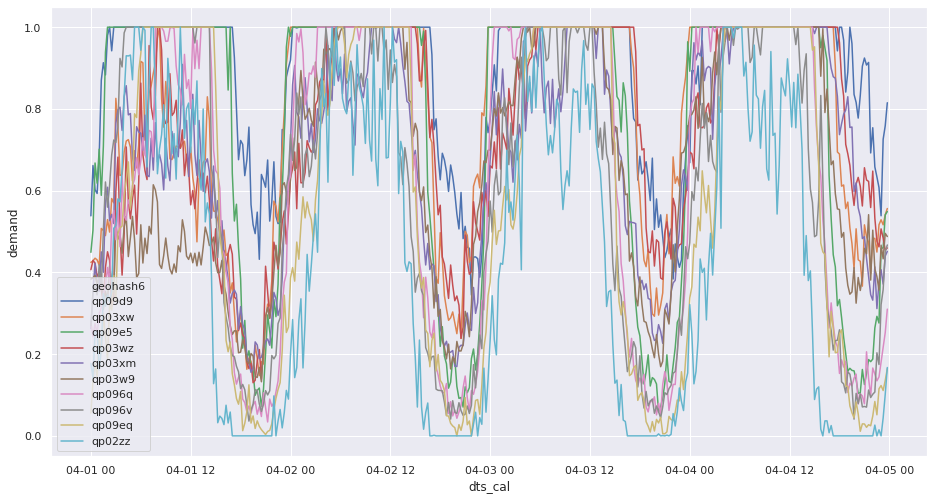

In [33]:
# observation 10 samples cluster's highest demand
top_clusters = list(OrderedDict.fromkeys([c[0] for c in trf_day1_complete[['cluster_ids']].values]))[0:10]
top_trf_day1_complete_highest = trf_day1_complete[(trf_day1_complete.cluster_ids.isin(top_clusters))]
#trf_week1_cl0_lower = pd.DataFrame(trf_week1[(trf_week1.highest_demand == False) & (trf_week1.cluster_ids == 0) & (trf_week1.demand > 0.0)])
#ax = sns.lineplot(x="dts_cal", y="demand", hue="geohash6", data=trf_week1_cl0_lower, legend="full")
#for l in ax.lines:
#    l.set_linestyle("--")
#    plt.setp(l,linewidth=1)
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(15.7,8.27)})
sns.lineplot(x="dts_cal", y="demand", hue="geohash6", data=top_trf_day1_complete_highest, legend="full")
plt.show()

# timeseries prediction

In [34]:
# prepare sorted data
total_sequence_series = 24*4*multiplier # 15 minutes within 24*multiplier hours
#past_length = int(((multiplier-1) / multiplier)*total_sequence_series)
prediction_length = int(24*4*(multiplier/4))
trf_day1_complete_sort = trf_day1_complete.sort_values(by=['cluster_ids','dts_cal'], ascending=True)
print("total_sequence_series: %s, prediction_length: %s" % (total_sequence_series, prediction_length))
trf_day1_complete_sort[:5]

total_sequence_series: 384, prediction_length: 96


,geohash6,day,timestamp,demand,dts_cal,latlon,lat,lon,cluster_ids,is_centroid,highest_demand,avg_demand
20,qp09s9,1,0:0,0.075299,2019-04-01 00:00:00,"(-5.35308837890625, 90.9063720703125)",-5.353088,90.906372,0,False,True,0.248135
109,qp09s9,1,0:15,0.128943,2019-04-01 00:15:00,"(-5.35308837890625, 90.9063720703125)",-5.353088,90.906372,0,False,True,0.248135
198,qp09s9,1,0:30,0.068149,2019-04-01 00:30:00,"(-5.35308837890625, 90.9063720703125)",-5.353088,90.906372,0,False,True,0.248135
287,qp09s9,1,0:45,0.057968,2019-04-01 00:45:00,"(-5.35308837890625, 90.9063720703125)",-5.353088,90.906372,0,False,True,0.248135
376,qp09s9,1,1:0,0.097595,2019-04-01 01:00:00,"(-5.35308837890625, 90.9063720703125)",-5.353088,90.906372,0,False,True,0.248135


In [35]:
# grouping and prepare prerequisite data
start_date = datetime.datetime.strptime('2019-03-31 00:00:00.00', '%Y-%m-%d %H:%M:%S.%f')
cluster_list = list(set([c for c in trf_day1_complete_sort['cluster_ids']]))
demand = trf_day1_complete_sort.groupby(['cluster_ids', 'dts_cal'])['demand'].apply(list)

In [36]:
def plot_forecasts(tss, forecasts, past_length, num_plots):
    for target, forecast in islice(zip(tss, forecasts), num_plots):
        ax = target[-past_length:].plot(figsize=(12,5), linewidth=2)
        forecast.plot(color='g')
        plt.grid(which='both')
        plt.legend(["observations", "median prediction", "90% confidence interval", "50% confidence interval"])
        plt.show()

INFO:root:Start model training
INFO:root:Number of parameters in DeepARTrainingNetwork: 13463
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 50/50 [00:13<00:00,  3.74it/s, avg_epoch_loss=-2.35]
INFO:root:Epoch[0] Elapsed time 13.357 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=-2.348080
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:12<00:00,  4.08it/s, avg_epoch_loss=-2.83]
INFO:root:Epoch[1] Elapsed time 12.247 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=-2.833990
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:12<00:00,  4.05it/s, avg_epoch_loss=-3]   
INFO:root:Epoch[2] Elapsed time 12.336 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=-2.998384
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:12<00:00,  4.00it/s, avg_epoch_loss=-3.12]
INFO:root:Epoch[3] Elapsed time 12.514 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=-3.115541
INFO:root:Epoch[4] Learning ra

INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=-3.519759
INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 50/50 [00:12<00:00,  4.11it/s, avg_epoch_loss=-3.41]
INFO:root:Epoch[37] Elapsed time 12.183 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=-3.412013
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:12<00:00,  4.09it/s, avg_epoch_loss=-3.41]
INFO:root:Epoch[38] Elapsed time 12.220 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=-3.410320
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:12<00:00,  4.07it/s, avg_epoch_loss=-3.53]
INFO:root:Epoch[39] Elapsed time 12.289 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=-3.526505
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:12<00:00,  4.05it/s, avg_epoch_loss=-3.55]
INFO:root:Epoch[40] Elapsed time 12.366 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=-3.554204
INFO:root:Epoch[41] Learning rate is 0.001
100%|███

100%|██████████| 50/50 [00:12<00:00,  4.08it/s, avg_epoch_loss=-3.69]
INFO:root:Epoch[73] Elapsed time 12.249 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=-3.690363
INFO:root:Epoch[74] Learning rate is 0.0005
100%|██████████| 50/50 [00:12<00:00,  4.05it/s, avg_epoch_loss=-3.63]
INFO:root:Epoch[74] Elapsed time 12.357 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=-3.630458
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 50/50 [00:12<00:00,  3.99it/s, avg_epoch_loss=-3.55]
INFO:root:Epoch[75] Elapsed time 12.535 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=-3.545156
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 50/50 [00:12<00:00,  4.08it/s, avg_epoch_loss=-3.73]
INFO:root:Epoch[76] Elapsed time 12.246 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=-3.730630
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 50/50 [00:12<00:00,  4.06it/s, avg_epoch_loss=-3.78]
INFO:root:Epoch[77] Elapsed time 12.32

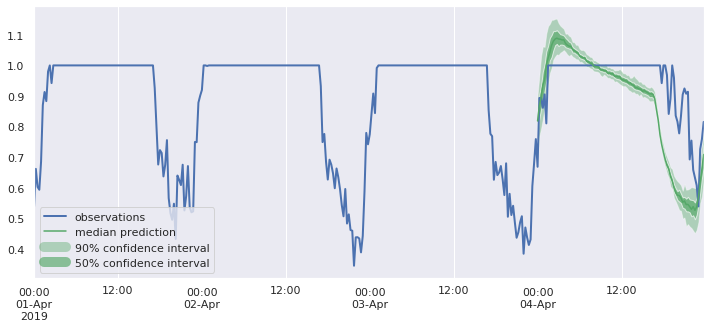

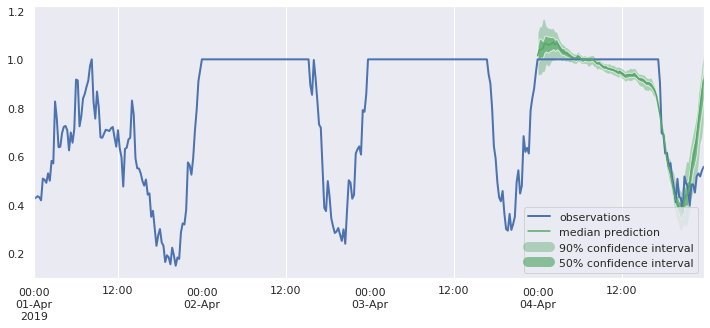

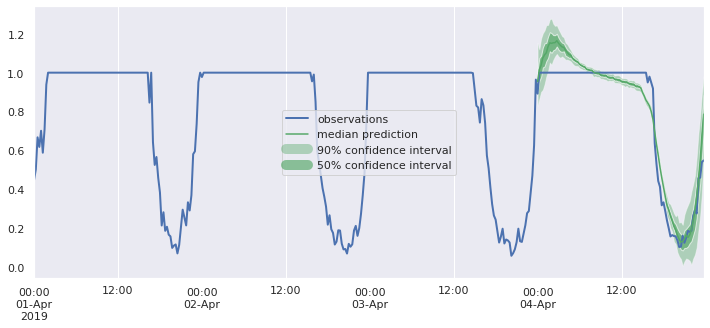

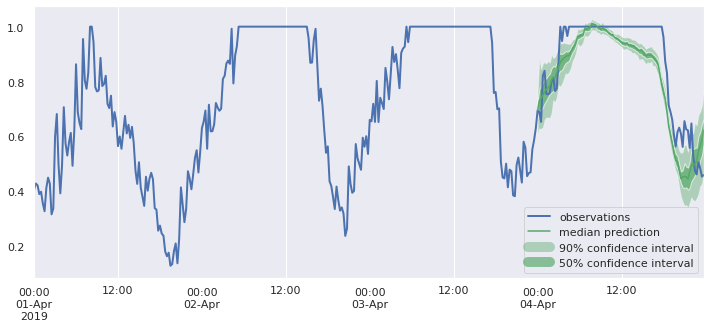

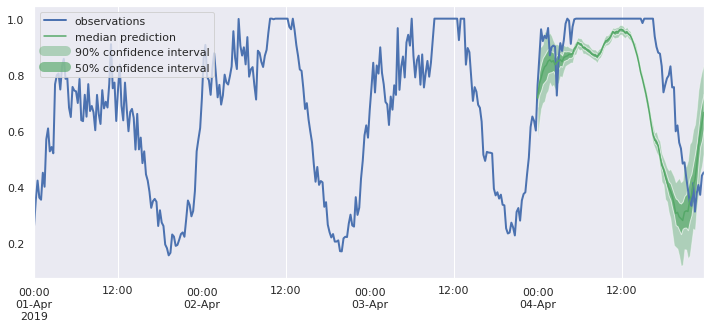

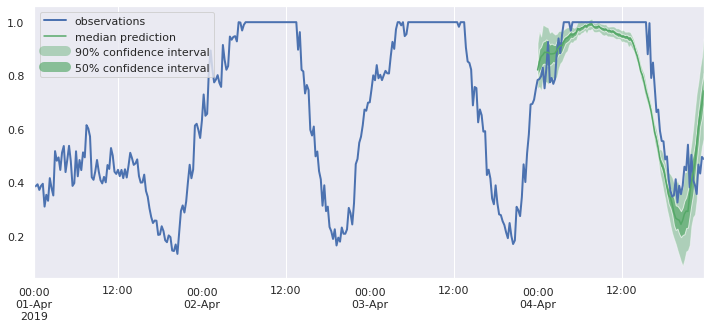

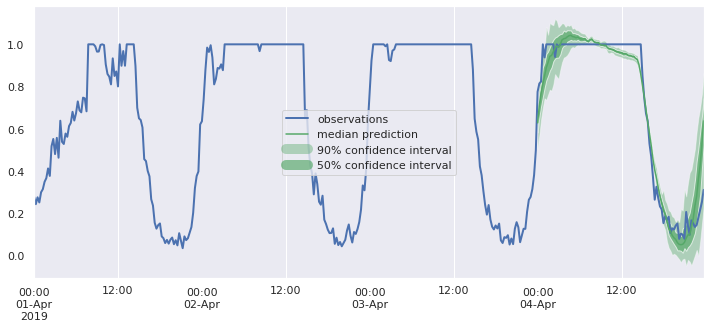

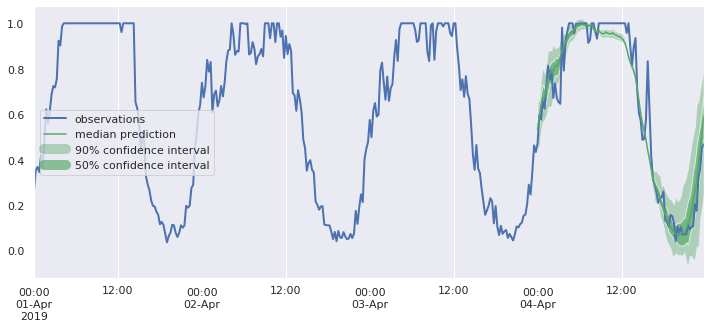

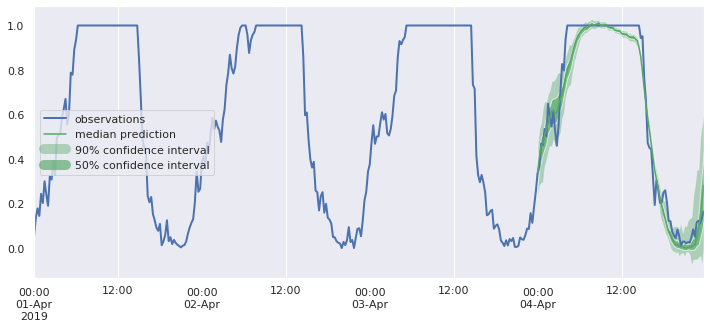

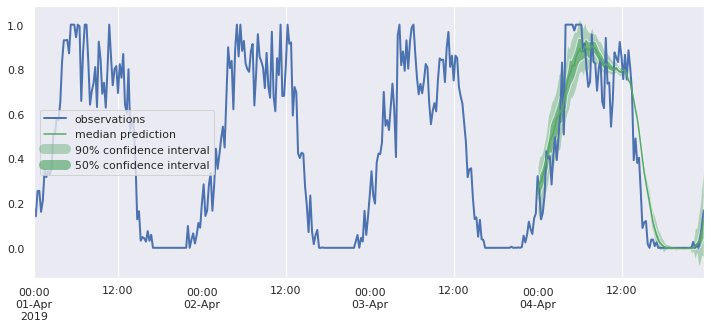

In [37]:
# start training, predicting and evaluating, first trial using gluonts default params
from gluonts.dataset import common
from gluonts.model import deepar
from gluonts.model import simple_feedforward
from gluonts.trainer import Trainer
from gluonts.evaluation import Evaluator
from gluonts.evaluation.backtest import make_evaluation_predictions

# setup train and test data for gluonts, train : predict == 3 : 4
train_day1_ds = [[demand[c][start_date + t][0] for t in interval_time[:-prediction_length]] for c in cluster_list]
test_day1_ds = [[demand[c][start_date + t][0] for t in interval_time] for c in cluster_list]

start = pd.Timestamp("2019-04-01 00:00:00", freq="15min")

# setup train data in gluonts format
train_ds = [{'target': x, 'start': start} for x in train_day1_ds]
train_data = common.ListDataset(train_ds, freq="15min")

# setup test data in gluonts format
test_ds = [{'target': x, 'start': start} for x in test_day1_ds]
test_data = common.ListDataset(test_ds, freq="15min")

estimator = deepar.DeepAREstimator(
    freq="15min",
    prediction_length=prediction_length,
    trainer=Trainer()
)
#estimator = simple_feedforward.SimpleFeedForwardEstimator(
#    freq="15min",
#    prediction_length=prediction_length,
#    trainer=Trainer()
#)
predictor = estimator.train(train_data)

forecast_it, ts_it = make_evaluation_predictions(
    test_data, predictor=predictor, num_eval_samples=100
)

forecasts = list(forecast_it)
tss = list(ts_it)

# plot for top 10 highest demand forecasts
top_forecasts = [forecasts[c] for c in top_clusters]
top_tss = [tss[c] for c in top_clusters]
plot_forecasts(top_tss, top_forecasts, past_length=total_sequence_series,num_plots=len(top_clusters))